In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
data_loc = "D:/Beam Characterization/2019_5_6/"
fname = "2019_05_06_ablation_power.hdf"

In [3]:
with h5py.File(data_loc+fname, 'r') as f:
    runs = list(f.keys())
    for name in f.keys():
        print(name)

1557166792 27mJ
1557167046 27mJ
1557167308 27mJ
1557167757 17mJ
1557168002 17mJ
1557168272 20mJ
1557168531 20mJ
1557168805 20mJ
1557169093 24mJ
1557169198 24mJ
1557169353 24mJ
1557169743 31mJ
1557169908 31mJ
1557170050 new_spot
1557170250 31mJ
1557170445 31mJ
1557170583 31mJ
1557170857 43mJ
1557170987 new_spot
1557171096 43mJ
1557171145 43mJ
1557171331 43mJ


In [4]:
pulse_energies = [17,20,24,27,31,43]
energy_runs = dict([(E,[]) for E in pulse_energies])
# '1557170250 31mJ' started the scan later, need to fix
bad_spot = ['1557170857 43mJ', '1557171096 43mJ', '1557169908 31mJ', '1557166792 27mJ', '1557168002 17mJ', '1557170250 31mJ']
for run in runs:
    if run in bad_spot:
        continue
    try:
        E = int(run[-4:-2])
        if E in pulse_energies:
            energy_runs[E].append(run)
    except:
        pass

E = 17


100%|█████████████████████████████████████████████████████████████████████████████| 319/319 [00:00<00:00, 15949.44it/s]


E = 20


100%|█████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 18819.19it/s]


E = 24


100%|█████████████████████████████████████████████████████████████████████████████| 322/322 [00:00<00:00, 17889.71it/s]


E = 27


100%|█████████████████████████████████████████████████████████████████████████████| 377/377 [00:00<00:00, 18839.46it/s]


E = 31


100%|█████████████████████████████████████████████████████████████████████████████| 351/351 [00:00<00:00, 19496.76it/s]


E = 43


100%|█████████████████████████████████████████████████████████████████████████████| 347/347 [00:00<00:00, 19315.25it/s]


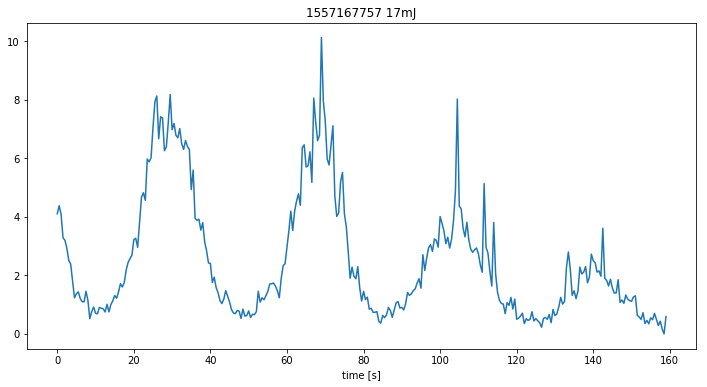

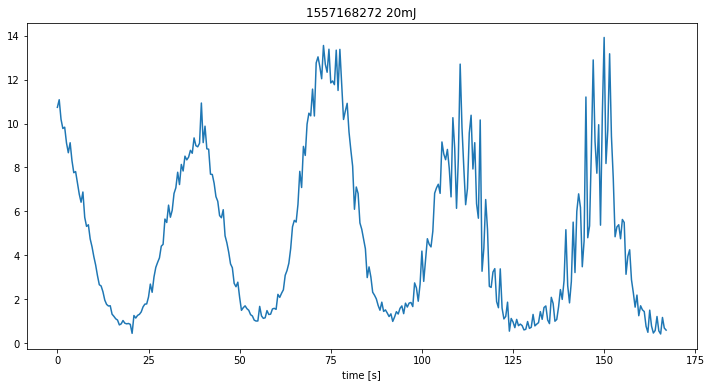

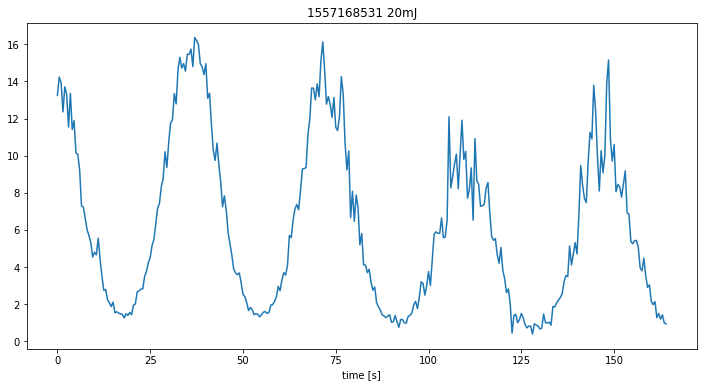

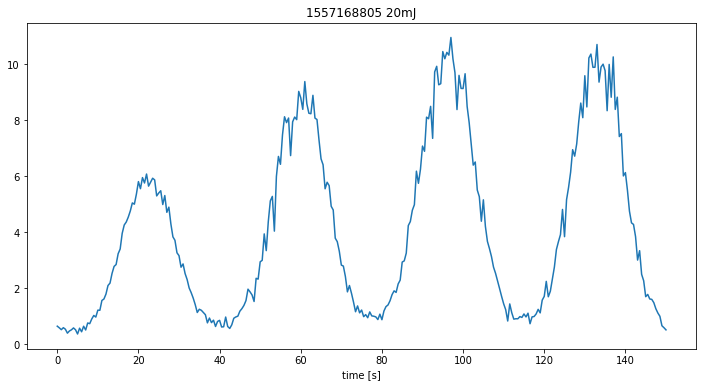

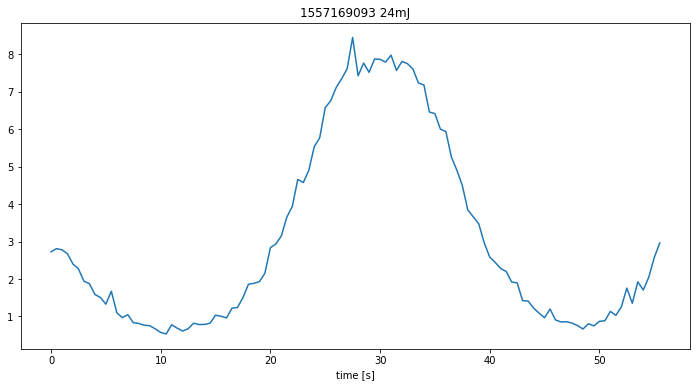

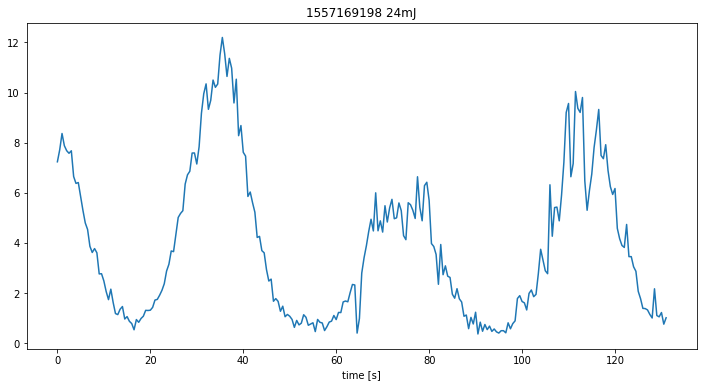

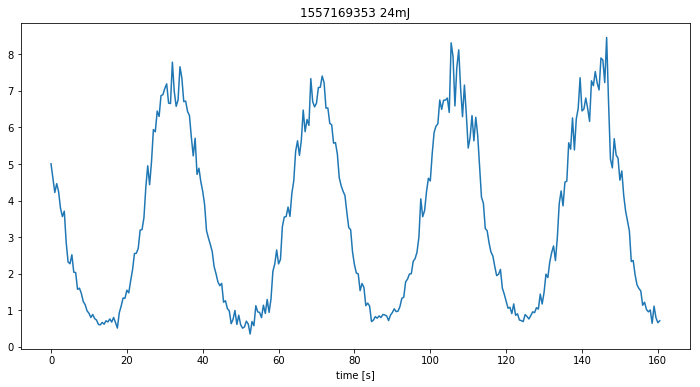

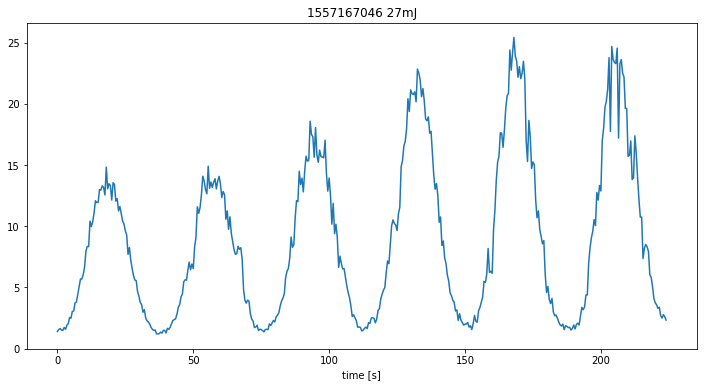

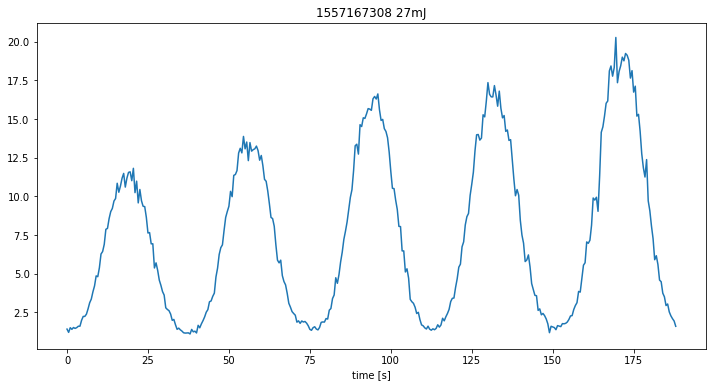

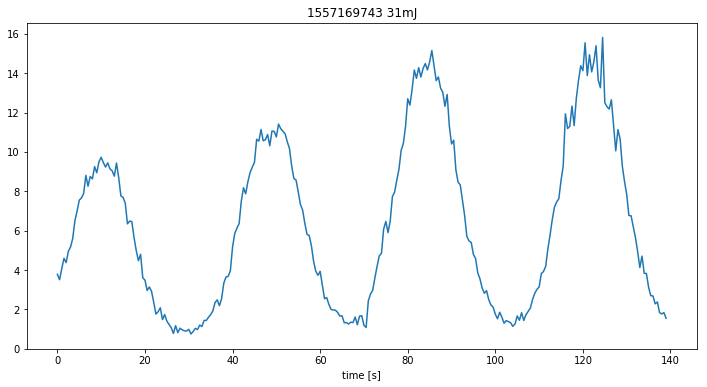

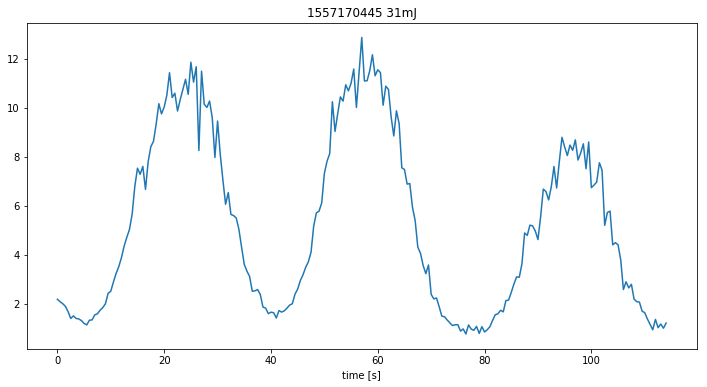

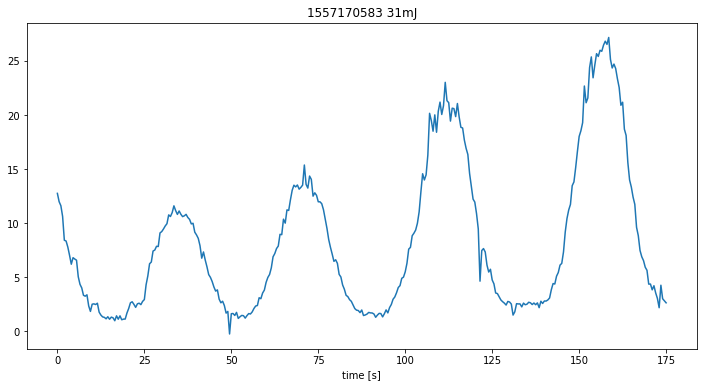

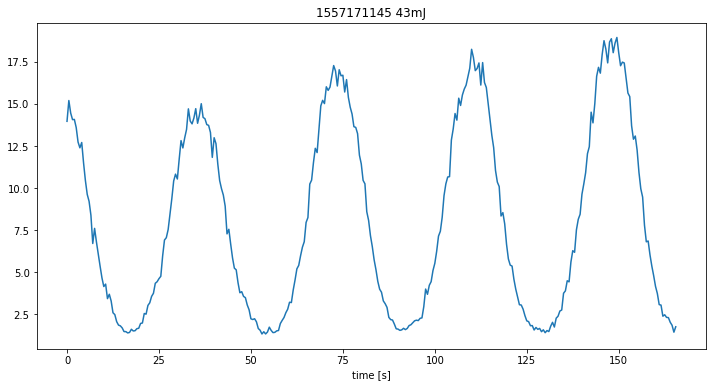

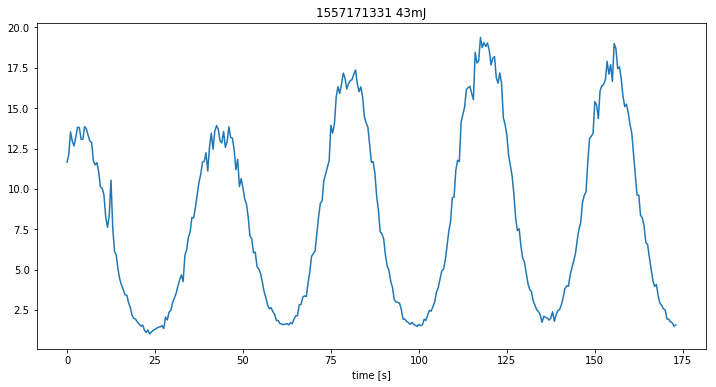

In [5]:
for E in pulse_energies:
    print('='*25)
    print('E = {0}'.format(E))
    print('='*25)
    for run in energy_runs[E]:
        fast_daq = {}
        with h5py.File(data_loc+fname, 'r') as f:
            grp = f[run]
            readout = grp['readout']
            wavemeter = readout['Bristol671A'].value
            fast_start = grp.attrs['time_offset']
            for dset in readout['PXIe-5171'].items():
                fast_daq[dset[0]] = dset[1].value

        integrals = []
        x = np.linspace(0,1500,1500)/100
        dx = 1/1e5

        yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]

        for idx in tqdm.tqdm(yag_fire):
            # Check if UV is on
            if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
                data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
                background = np.trapz(data_f[-200:], dx=dx)
                signal = np.trapz(data_f[100:-200], dx=dx)-17/2*background
                integrals.append((idx,-signal,-background))
        integrals = np.array(integrals)
        fig, ax = plt.subplots(figsize = (12,6))
        ax.plot(np.arange(len(integrals[:,1]))*0.5,integrals[:,1])
        ax.set_title(run)
        ax.set_xlabel('time [s]')

In [6]:
from lmfit import models
from lmfit import Model
from scipy.signal import find_peaks
from datetime import datetime

start_times = []

for E in pulse_energies:
    for run in energy_runs[E]:
        with h5py.File(data_loc+fname, 'r') as f:
            grp = f[run]
            readout = grp['readout']
            fast_start = grp.attrs['time_offset']
        
            start_times.append((run, datetime.fromtimestamp(fast_start).strftime('%Y-%m-%d %H:%M:%S')))

In [7]:
start_times

[('1557167757 17mJ', '2019-05-06 14:35:56'),
 ('1557168272 20mJ', '2019-05-06 14:44:31'),
 ('1557168531 20mJ', '2019-05-06 14:48:51'),
 ('1557168805 20mJ', '2019-05-06 14:53:25'),
 ('1557169093 24mJ', '2019-05-06 14:58:12'),
 ('1557169198 24mJ', '2019-05-06 14:59:57'),
 ('1557169353 24mJ', '2019-05-06 15:02:33'),
 ('1557167046 27mJ', '2019-05-06 14:24:03'),
 ('1557167308 27mJ', '2019-05-06 14:28:27'),
 ('1557169743 31mJ', '2019-05-06 15:09:03'),
 ('1557170445 31mJ', '2019-05-06 15:20:45'),
 ('1557170583 31mJ', '2019-05-06 15:23:03'),
 ('1557171145 43mJ', '2019-05-06 15:32:25'),
 ('1557171331 43mJ', '2019-05-06 15:35:30')]

## Laser Locking HDF file

Opening and loading the laser locking HDF file

In [8]:
import glob
fnames_locking = [f.split('\\')[-1] for f in glob.glob(data_loc+'/*.hdf5')]
fnames_locking = [f for f in fnames_locking if f[:4] == 'logS']
        
locking_data = {}
for fname_lock in fnames_locking:
    with h5py.File(data_loc+fname_lock, 'r') as f:
        tmp = []
        tmp.append(('timestamp', f['Time'].value))
        tmp.append(('frequency', f['RealFrequency'].value))
        tmp.append(('error', f['Errors'].value))
        tmp.append(('green_power',f['Power'].value))
        
        locking_data[datetime.strptime(fname_lock.strip('.hdf5')[5:], '%Y-%m-%d-%H.%M.%S')] = dict(tmp)

## Synchronizing timestamps

In [9]:
run_to_locking = {}
for run, start_time_run in start_times:
    tstart_run = datetime.strptime(start_time_run, '%Y-%m-%d %H:%M:%S')
    run_to_locking[run] = list(locking_data.keys())[np.where(np.array(list(locking_data.keys())) < tstart_run)[0][-1]]

In [10]:
run_to_locking

{'1557167757 17mJ': datetime.datetime(2019, 5, 6, 14, 35, 26),
 '1557168272 20mJ': datetime.datetime(2019, 5, 6, 14, 35, 26),
 '1557168531 20mJ': datetime.datetime(2019, 5, 6, 14, 35, 26),
 '1557168805 20mJ': datetime.datetime(2019, 5, 6, 14, 35, 26),
 '1557169093 24mJ': datetime.datetime(2019, 5, 6, 14, 35, 26),
 '1557169198 24mJ': datetime.datetime(2019, 5, 6, 14, 35, 26),
 '1557169353 24mJ': datetime.datetime(2019, 5, 6, 14, 35, 26),
 '1557167046 27mJ': datetime.datetime(2019, 5, 6, 14, 23, 24),
 '1557167308 27mJ': datetime.datetime(2019, 5, 6, 14, 23, 24),
 '1557169743 31mJ': datetime.datetime(2019, 5, 6, 14, 35, 26),
 '1557170445 31mJ': datetime.datetime(2019, 5, 6, 15, 17, 39),
 '1557170583 31mJ': datetime.datetime(2019, 5, 6, 15, 17, 39),
 '1557171145 43mJ': datetime.datetime(2019, 5, 6, 15, 31, 16),
 '1557171331 43mJ': datetime.datetime(2019, 5, 6, 15, 31, 16)}

In [11]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice.


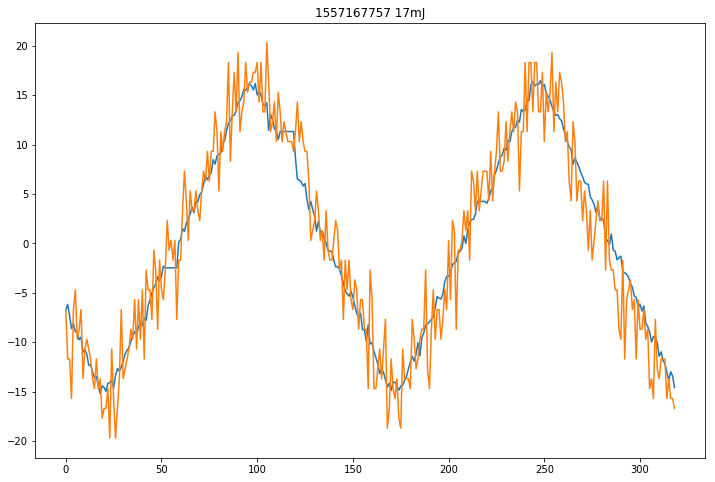

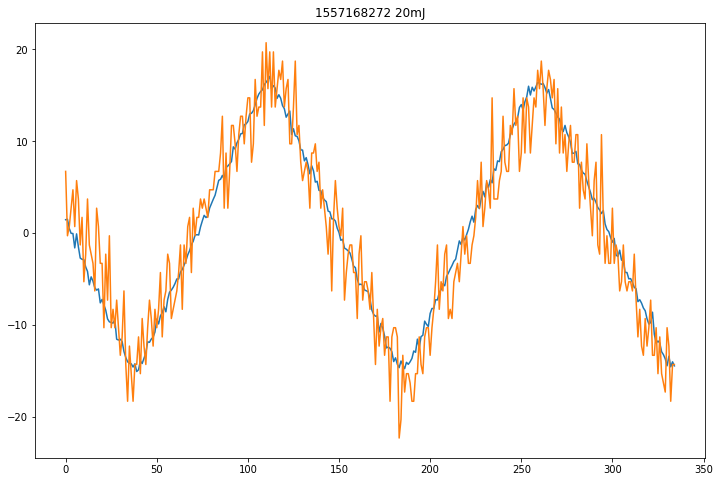

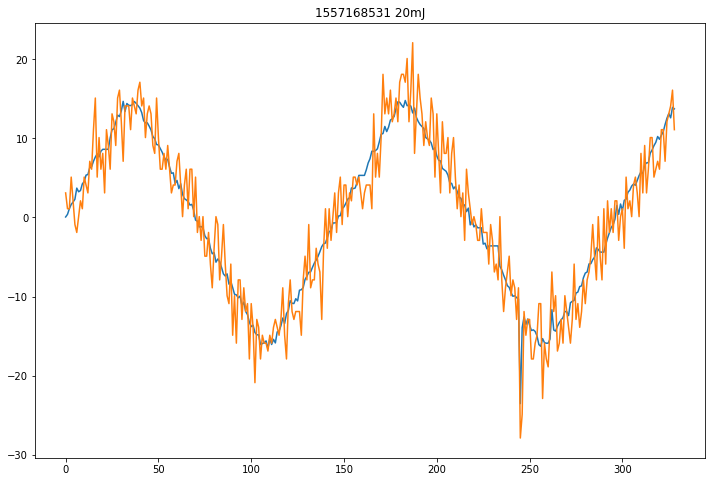

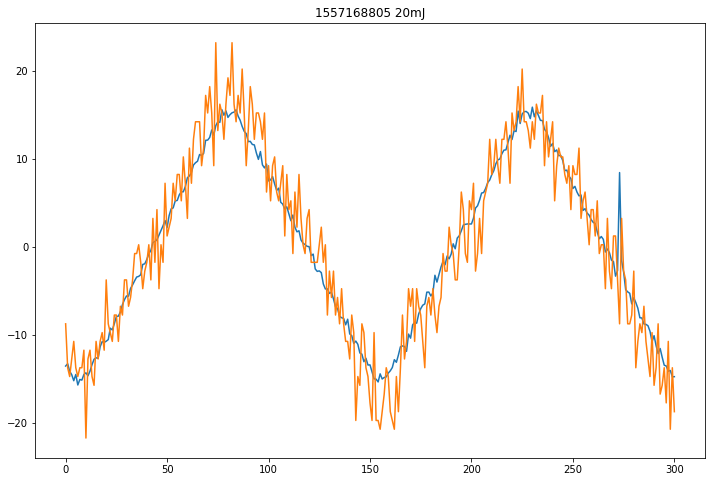

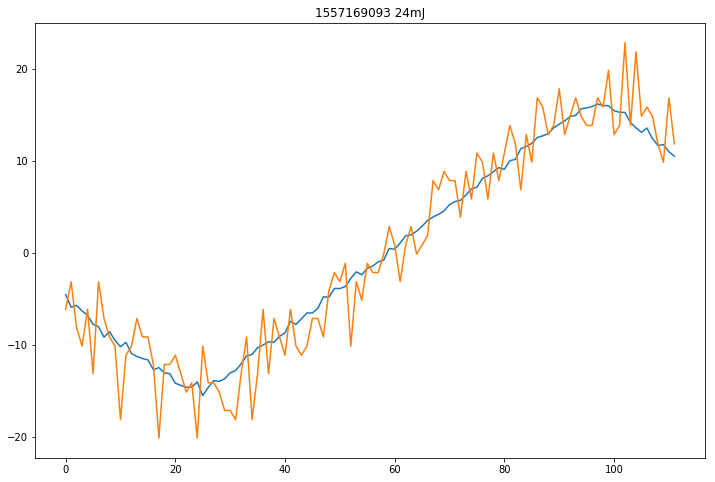

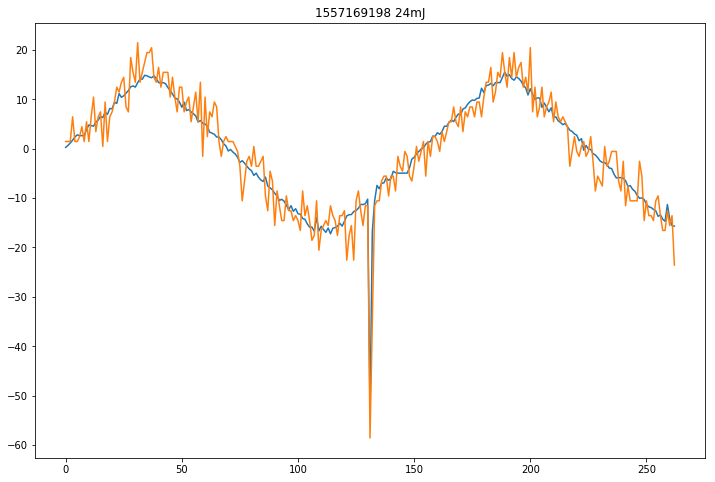

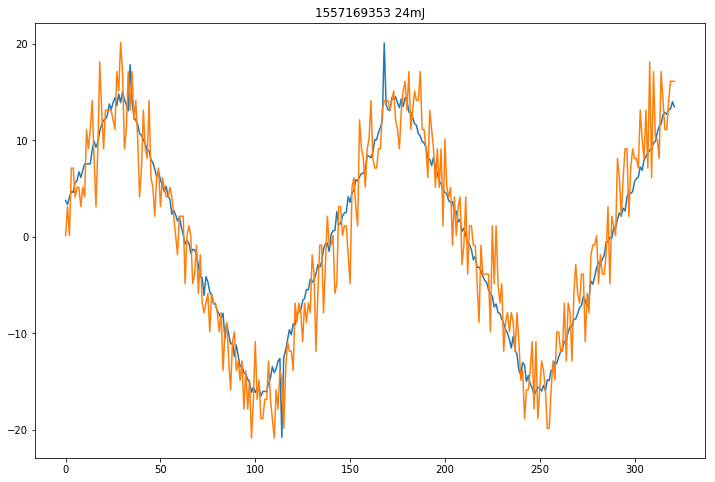

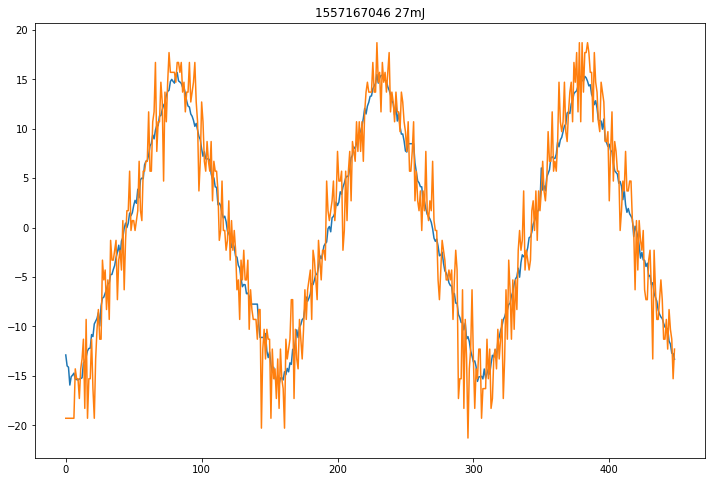

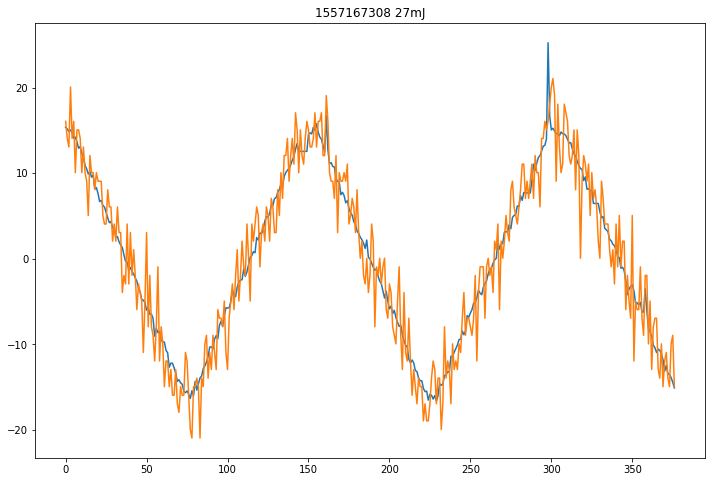

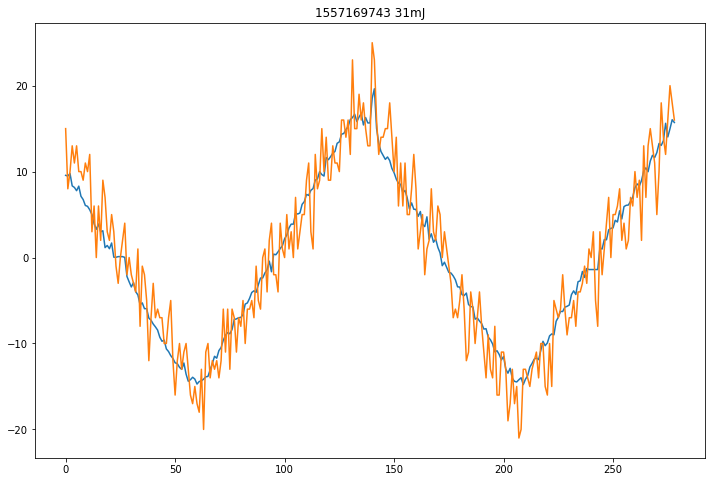

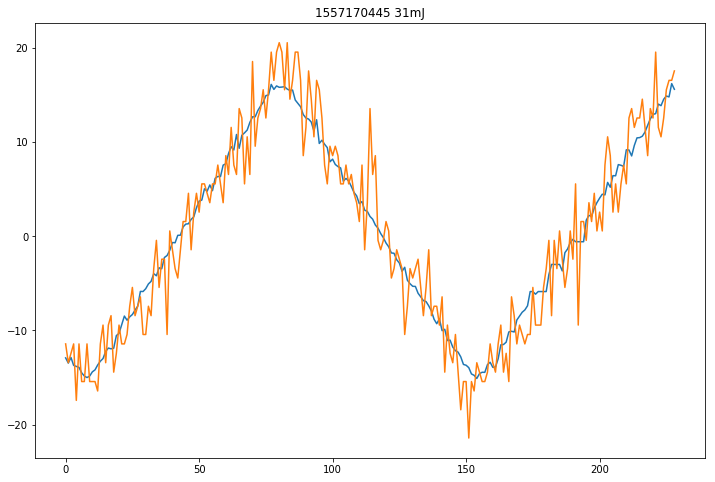

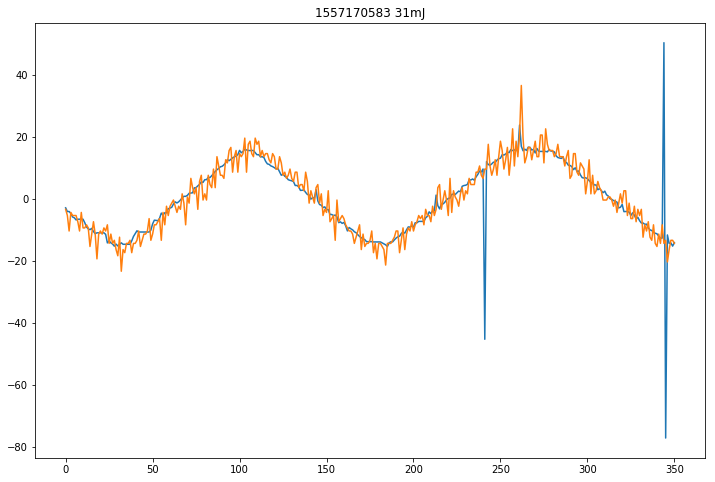

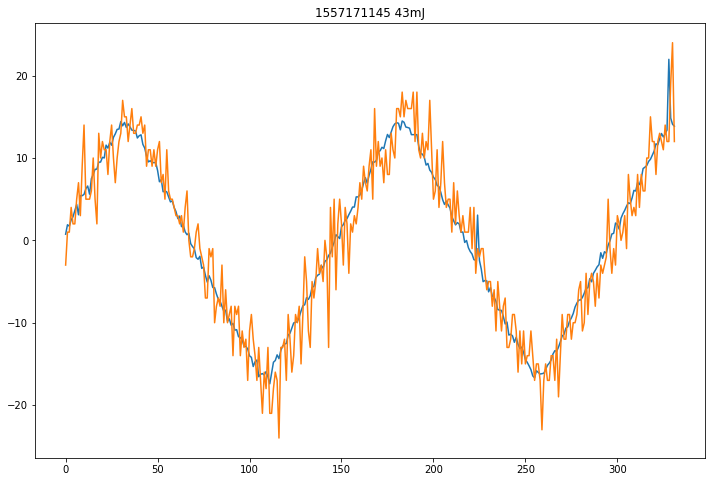

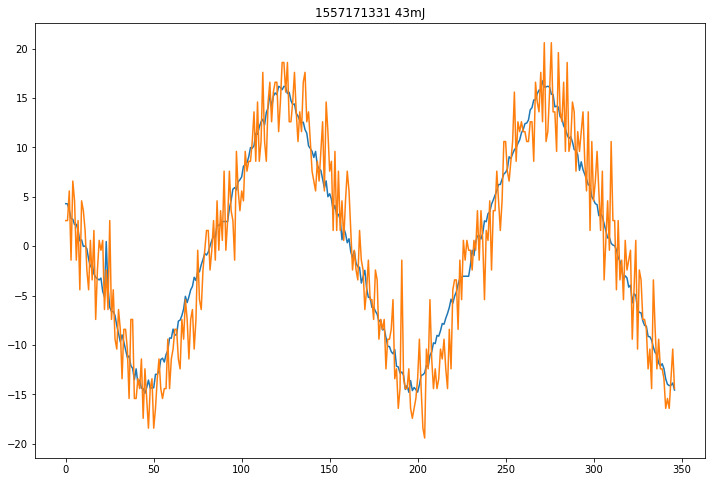

In [17]:
from lmfit import models
from lmfit import Model
from scipy.signal import find_peaks

pulse_energy_peaks = {}

for E in pulse_energies:
    pulse_energy_peaks[E] = []
    for run in energy_runs[E]:
        fast_daq = {}
        with h5py.File(data_loc+fname, 'r') as f:
            grp = f[run]
            readout = grp['readout']
            wavemeter = readout['Bristol671A'].value
            fast_start = grp.attrs['time_offset']
            for dset in readout['PXIe-5171'].items():
                fast_daq[dset[0]] = dset[1].value
                
        
        # grabing the dictinary key for the correct locking data file for each fast data acquisition run
        locking = run_to_locking[run]
        
        # grabbing the timestamps from the locking data
        timestamps_locking = locking_data[locking]['timestamp'].astype(float)+locking.timestamp()
        frequencies_locking = -1*locking_data[locking]['frequency']
        
        # only selecting datasets where the yag was fired
        yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]
        
        # grabbing corresponding wavemeter readout values        
        rate = 1/2
        wavelength_values = []
        for idx in yag_fire:
            wavelength_values.append((idx, wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
        wavelength_values = np.array(wavelength_values) 
        
        # grabbing corresponding locking frequency from locking hdf file
        rate = 1/2
        frequency_values = []
        for idx in yag_fire:
            frequency_values.append((idx,frequencies_locking[find_nearest_idx(timestamps_locking, idx*rate+fast_start-1.4)]))
        frequency_values = np.array(frequency_values)
        
        fig, ax = plt.subplots(figsize = (12,8))
        ax.plot(frequency_values[:,1]-frequency_values[:,1].mean())
        ax.plot((wavelength_values[:,1]-wavelength_values[:,1].mean())*1e6)
        ax.set_title(run)
        
        # integrating the pmt signal and subtracting the background
        integrals = []
        for idx in yag_fire:
            # Check if UV is on
            if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
                data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
                background = np.trapz(data_f[:100], dx=dx)
                signal = np.trapz(data_f[200:1100], dx=dx)-9*background
                integrals.append((idx,signal*-1,background*-1))
        integrals = np.array(integrals)
        
        # making an array with the integral amplitude and corresponding frequency
        frequency_amp = []
        for val in integrals:
            idx_int = val[0]
            frequency_amp.append((dict(frequency_values)[idx_int], val[1], idx_int))
        frequency_amp = np.array(frequency_amp)

        # putting each up and down part of a scan in a separate list entry to fit the peaks separately
        freq_low, freq_high = -447, -420
        left = np.where(np.diff(((frequency_values[:,1] > freq_low) & (frequency_values[:,1] < freq_high)).astype(int)) == -1)[0]+1
        right = np.where(np.diff(((frequency_values[:,1] > freq_low) & (frequency_values[:,1] < freq_high)).astype(int)) == 1)[0]+1
        indices = np.sort(np.append(left, right))
        indices = np.append(np.array([0]),indices)
        indices = np.append(indices, [-1])
        del left, right

        split_points = [0]
        for l,r in zip(indices[:-1], indices[1:]):
            vals = frequency_values[l:r,1]
            if (r-l >= 5) & ((vals.min() < freq_low) or (vals.max() > freq_high)):
                split_points.append(int(np.mean([l,r])))
        split_points.append(len(frequency_values))

        # grabbing the frequencies and peak integrals from the up and down scans
        scans = []
        for l,r in zip(split_points[:-1], split_points[1:]):
            if r-l > 50:
                scans.append([frequency_values[l:r,1], integrals[l:r,1]])
        
        # fitting each up and down scan separately
        for f, i in scans:
            fit_array = np.array([f[f.argsort()], i[f.argsort()]]).T
            
            # removing data points with frequencies outside of the peak range
            fit_array = fit_array[(fit_array[:,0] > freq_low) & (fit_array[:,0] < freq_high)]

            # binning the data to get a crude estimate of the error on each frequency value
            df = 2
            f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
            bin_indices = np.digitize(fit_array[:,0], f_bins)
            bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
            bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
            midpoint = np.diff(f_bins)/2+f_bins[:-1]

            mask_nan = ~np.isnan(bin_means)
            bin_means = bin_means[mask_nan]
            bin_errors = bin_errors[mask_nan]
            midpoint = midpoint[mask_nan]
        
            # finding the peak parameters such as height, center, and width
            minimum_peak_height = 2
            distance = np.ceil(1/np.diff(midpoint)[0])
            width = 3/np.diff(midpoint)[0]
            peaks = find_peaks(bin_means, height = minimum_peak_height, threshold = None, distance = distance, width = width)
            
            # fitting the peak (Voigt) plus a constant offset
            def offset(x, offset):
                return np.ones(len(x))*offset
            
            model_bg = Model(offset)
            model_peak = models.VoigtModel(prefix = 'Q23_')
            model = model_bg + model_peak
            try:
                sigma = np.diff(midpoint)[0]*peaks[1]['widths'][0]/(2*1.6)
            except Exception as e:
                print(peaks)
                ax.plot(midpoint, bin_means)
                raise e
            center = midpoint[peaks[0][0]]
            height = peaks[1]['peak_heights'][0]*np.sqrt(2*np.pi*sigma**2)*1.5
            params = {'offset': bin_means.min(),
                      'Q23_sigma': sigma, 
                      'Q23_center': center, 
                      'Q23_amplitude': height}
            result = model.fit(bin_means, **params, x=midpoint, weights = bin_errors)
            pulse_energy_peaks[E].append((run, result))          

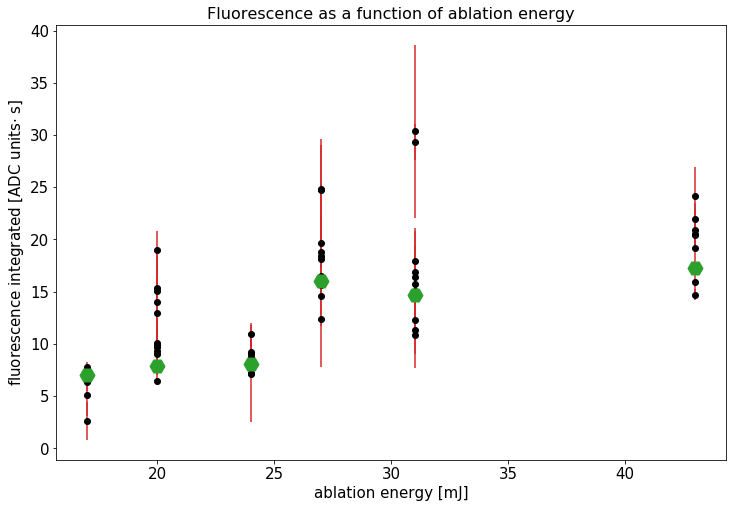

In [65]:
def weighted_mean(vals, weights):
    mean = np.sum(np.array(vals)*np.array(weights))/np.sum(weights)
    stderr = np.sqrt(np.sum(weights))**-1
    return mean, stderr

fig, ax = plt.subplots(figsize = (12,8))

for E in pulse_energies:
    m, w = [], []
    for val in pulse_energy_peaks[E]:
        m.append(val[1].params['Q23_height'].value)
        w.append(1/val[1].params['Q23_height'].stderr**2)
        ax.errorbar(E, val[1].params['Q23_height'].value, yerr = val[1].params['Q23_height'].stderr, fmt ='.', ecolor = 'C3', ms = 12, color = 'k')
    wm, wstderr = weighted_mean(m,w)
    ax.errorbar(E, wm, yerr = wstderr, fmt ='H', ecolor = 'C3', ms = 15, color = 'C2')

ax.set_title('Fluorescence as a function of ablation energy', fontsize = 16)
ax.set_xlabel('ablation energy [mJ]', fontsize = 15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)

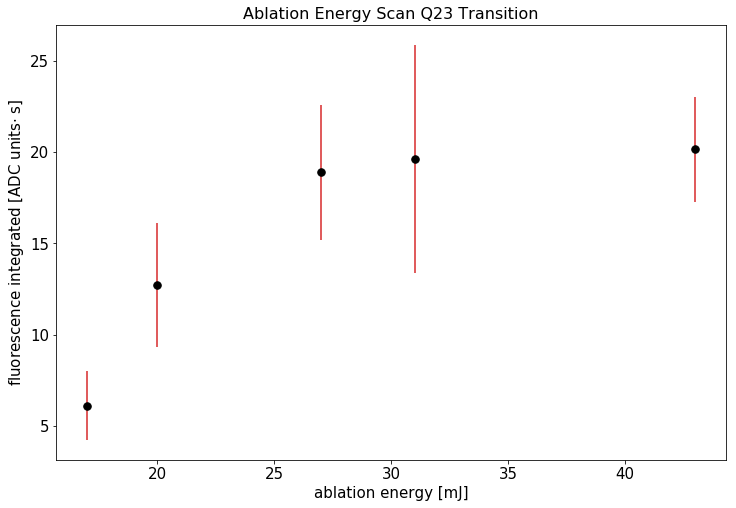

In [78]:
fig, ax = plt.subplots(figsize = (12,8))

for E in pulse_energies:
    m, w = [], []
    if E == 24:
            continue
    for val in pulse_energy_peaks[E]:
        m.append(val[1].params['Q23_height'].value)
        w.append(val[1].params['Q23_height'])

    wm, wstderr = weighted_mean(m,w)
    ax.errorbar(E, wm, yerr = np.std(w), fmt ='.', ecolor = 'C3', ms = 15, color = 'k')

ax.set_title('Ablation Energy Scan Q23 Transition', fontsize = 16)
ax.set_xlabel('ablation energy [mJ]', fontsize = 15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)
fig.savefig('abblation_power_scan.png')

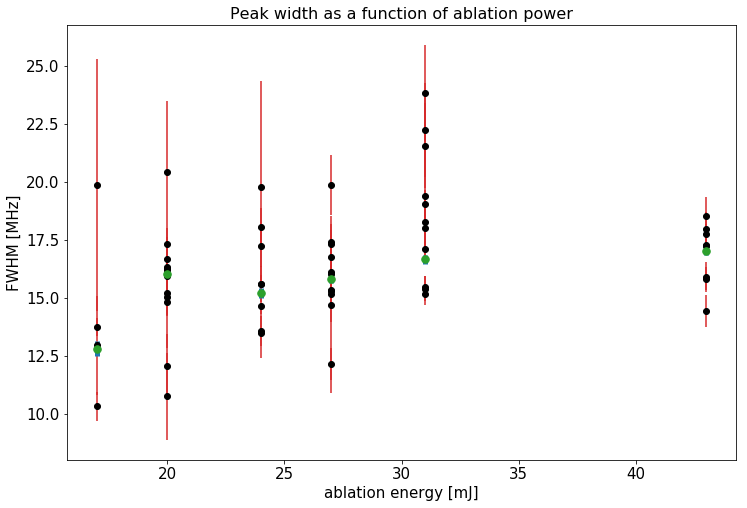

In [66]:
fig, ax = plt.subplots(figsize = (12,8))

for E in pulse_energies:
    m, w = [], []
    for val in pulse_energy_peaks[E]:
        if val[1].params['Q23_height'].stderr > 20:
            continue
        m.append(val[1].params['Q23_fwhm'].value)
        w.append(1/val[1].params['Q23_fwhm'].stderr**2)
        ax.errorbar(E, val[1].params['Q23_fwhm'].value, yerr = val[1].params['Q23_fwhm'].stderr, fmt ='.', ecolor = 'C3', ms = 12, color = 'k')
    wm, wstderr = weighted_mean(m,w)
    ax.errorbar(E, wm, yerr = wstderr, fmt ='.', ecolor = 'C0', ms = 15, color = 'C2', elinewidth = 5)

ax.set_title('Peak width as a function of ablation power', fontsize = 16)
ax.set_xlabel('ablation energy [mJ]', fontsize = 15)
ax.set_ylabel('FWHM [MHz]', fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)

In [69]:
m, w = [], []
for E in pulse_energies:
    for val in pulse_energy_peaks[E]:
        if val[1].params['Q23_height'].stderr > 20:
            continue
        m.append(val[1].params['Q23_fwhm'].value)
        w.append(1/val[1].params['Q23_fwhm'].stderr**2)
wm, wstderr = weighted_mean(m,w)
print('FWHM = {0:.2f} +/- {1:.2f} MHz'.format(wm, wstderr))

FWHM = 16.01 +/- 0.08 MHz
